# NEWS Virality Prediction

In [1]:
import requests
from bs4 import BeautifulSoup
from newspaper import Article 
import pandas as pd 
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import RandomForestRegressor

## Web Scrapping

In [2]:
url="https://news.yahoo.com/world"
req=requests.get(url)

In [3]:
soup=BeautifulSoup(req.content,'html.parser')
data=soup.findAll('a', attrs = {'class':['Fw(b) Fz(20px) Lh(23px) Fz(17px)--sm1024 Lh(19px)--sm1024 mega-item-header-link Td(n) C(#0078ff):h C(#000) LineClamp(2,46px) LineClamp(2,38px)--sm1024 not-isInStreamVideoEnabled']})

In [4]:
news=[]
for row in data: 
    if not row['href'].startswith('https'):
        news.append(url+row['href'])

In [5]:

df=[]
for nws in news:
    article = Article(nws, language="en")
    article.download() 
    article.parse() 
    article.nlp() 
    dict={}
    dict['Title']=article.title
    dict['Text']=article.text
    dict['Summary']=article.summary
    dict['Keywords']=article.keywords
    df.append(dict)

In [6]:
data=pd.DataFrame(df)
data.head()

,Keywords,Summary,Text,Title
0,"[endorse, secretary, virtual, familiar, vuccia...","Vice President Joe Biden, left, laughs with fo...","Vice President Joe Biden, left, laughs with fo...",Hillary Clinton to endorse Biden later Tuesday
1,"[leader, fined, ivory, soro, coast, absentia, ...",Guillaume Soro lives in France and was not pre...,Guillaume Soro lives in France and was not pre...,Former Ivory Coast rebel leader Guillaume Soro...
2,"[greater, christians, reveals, international, ...","WASHINGTON, April 28, 2020 /PRNewswire/ -- Fam...","WASHINGTON, April 28, 2020 /PRNewswire/ -- Fam...",2020 USCIRF Annual Report: Coronavirus Reveals...
3,"[amid, leader, power, quarantine, crime, coron...","The logos of Spain's soccer teams Barcelona, l...","The logos of Spain's soccer teams Barcelona, l...","El Salvador leader fights crime and virus, ami..."
4,"[infections, wieler, reproduction, factor, loc...",Shoppers out and about in Berlin as the German...,Shoppers out and about in Berlin as the German...,Germans urged to stay at home as key virus mea...


# Model


In [7]:
def rename_cols(data):
    """renames the column names by stripping and lowercase."""
    rename_cols_val = {x:x.lower().strip() for x in list(data)}
    return data.rename(index=str, columns=rename_cols_val)

def TrainTestSplit(X, Y, R=0, test_size=0.2):
    """Easy Train Test Split call."""
    return train_test_split(X, Y, test_size=test_size, random_state=R)

In [8]:
dataset = rename_cols(pd.read_csv('OnlineNewsPopularity.csv'))


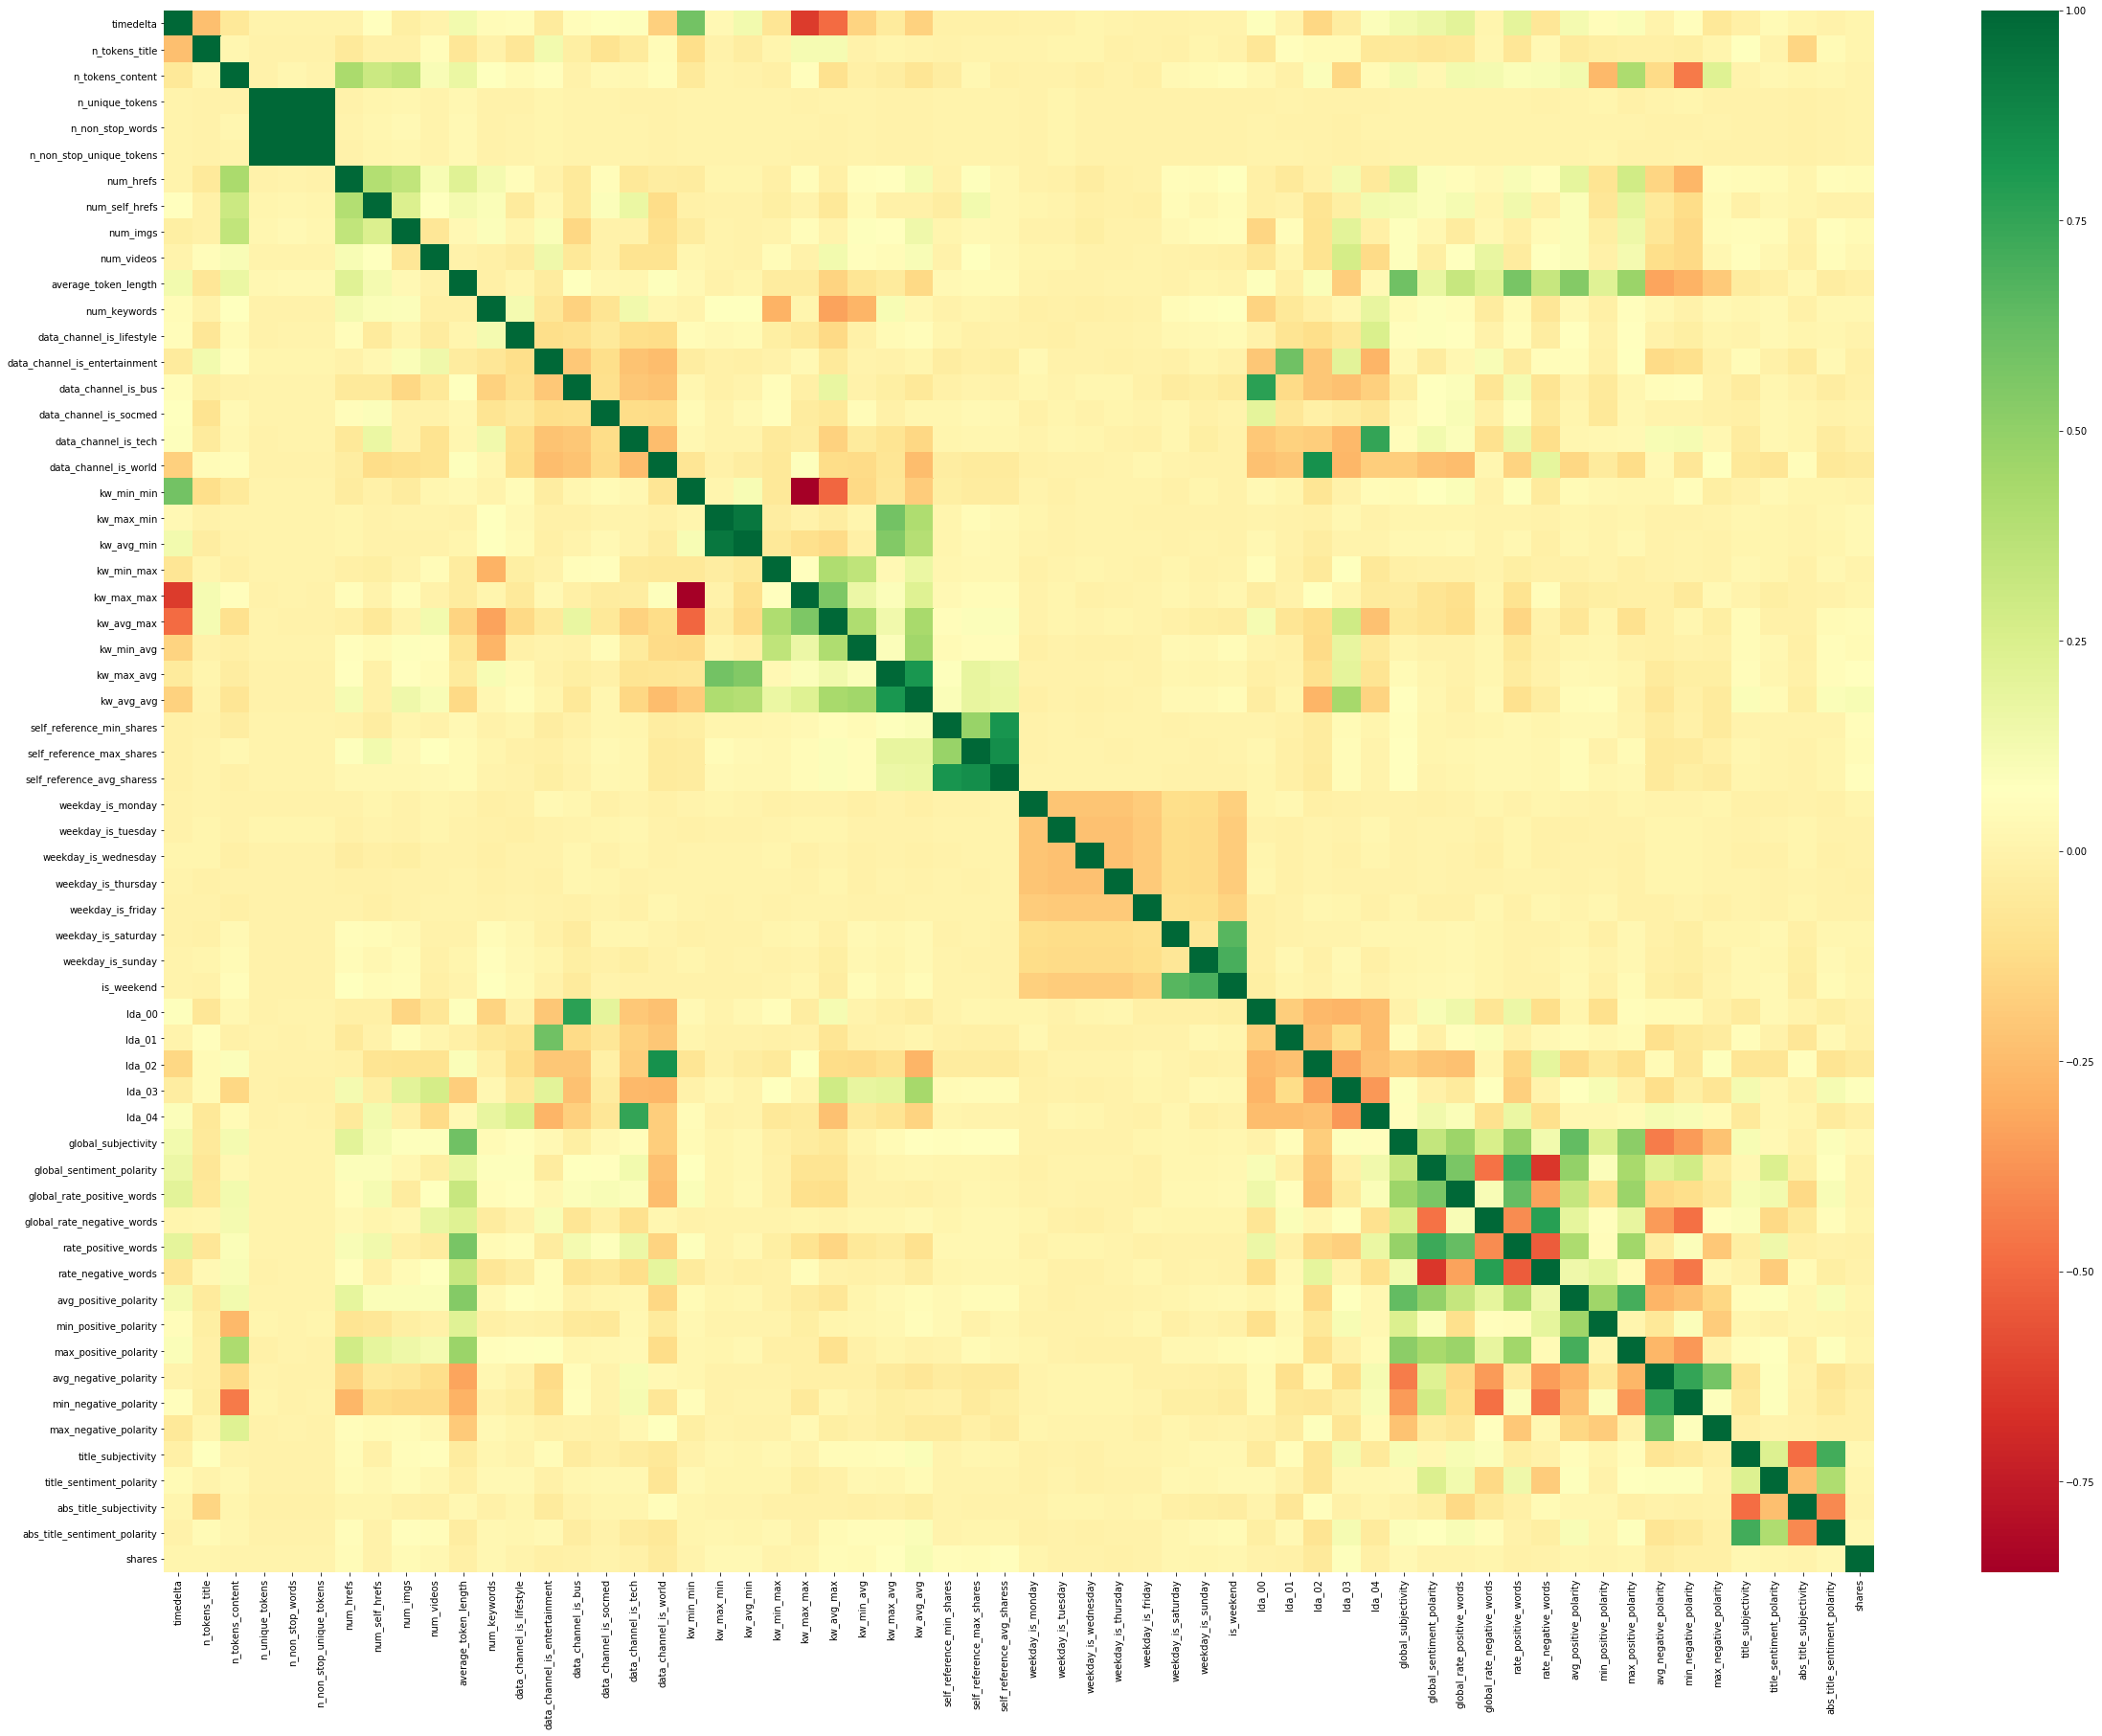

In [9]:
plt.figure(figsize=(40,30))
cor = dataset.corr(method ='pearson')
sns.heatmap(cor, cmap="RdYlGn")
plt.show()

## Feature Selection

By the above correlation graph we can clearly say that these features: • number of unique words and number of non-stop-words and number of non-stop-unique tokens • Kw-avg- min and kw-max-min These are strongly correlated and linearly dependent which makes us to assume that these features are so linearly dependent that any one of the strong correlated feature can be used and excluding the other features won’t affect the model and will be indirectly helpful in our model by not allowing to do overfitting.
I have also droped some extra features as extraction of these features from scrapped news data would be really hard.

In [10]:
dataset=dataset.drop(['url','n_non_stop_words','n_unique_tokens','timedelta', 'lda_00','lda_01','lda_02','lda_03','lda_04','num_self_hrefs', 'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','rate_positive_words','rate_negative_words','abs_title_subjectivity','abs_title_sentiment_polarity'], axis=1)
dataset.head()

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,...,global_rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,shares
0,12.0,219.0,0.815385,4.0,1.0,0.0,4.680365,5.0,0.0,1.0,...,0.013699,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,593
1,9.0,255.0,0.791946,3.0,1.0,0.0,4.913725,4.0,0.0,0.0,...,0.015686,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,711
2,9.0,211.0,0.663866,3.0,1.0,0.0,4.393365,6.0,0.0,0.0,...,0.009479,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,1500
3,9.0,531.0,0.665635,9.0,1.0,0.0,4.404896,7.0,0.0,1.0,...,0.020716,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,1200
4,13.0,1072.0,0.540890,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,...,0.012127,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,505


In [11]:
dataset.isna().sum() # no null values

n_tokens_title                   0
n_tokens_content                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
weekday_is_monday                0
weekday_is_tuesday               0
weekday_is_wednesday             0
weekday_is_thursday              0
weekday_is_friday                0
weekday_is_saturday              0
weekday_is_sunday                0
is_weekend                       0
global_subjectivity              0
global_sentiment_polarity        0
global_rate_positive_words       0
global_rate_negative_words       0
avg_positive_polarity            0
min_positive_polarity            0
max_positive_polarit

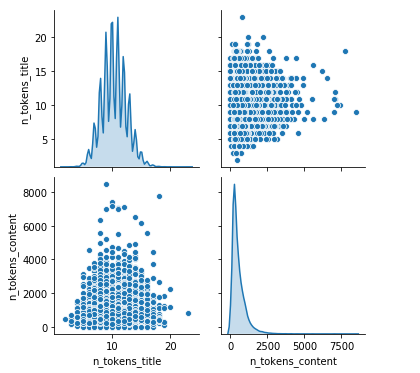

In [12]:
sns.pairplot(dataset[["n_tokens_title","n_tokens_content"]], diag_kind="kde")

### Feature Engineering

In [13]:
x = dataset.values #returns a numpy array
cols=list(dataset.columns)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled,columns=cols)

In [14]:
labels =dataset['shares']
dataset=dataset.drop(['shares'],axis=1)



In [15]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

In [16]:
X_train.head()

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,...,global_rate_positive_words,global_rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity
19837,0.619048,0.074109,0.000992,0.046053,0.007812,0.0,0.633059,0.666667,0.0,0.0,...,0.163857,0.060274,0.275971,0.033333,0.8,0.740816,0.500000,0.900000,0.458333,0.666667
904,0.428571,0.048265,0.001012,0.006579,0.007812,0.0,0.616603,0.333333,0.0,0.0,...,0.298768,0.092547,0.295343,0.136364,0.5,0.866667,0.833333,0.900000,0.000000,0.500000
23876,0.238095,0.040713,0.001206,0.016447,0.007812,0.0,0.614563,0.444444,0.0,0.0,...,0.316908,0.062695,0.428715,0.062500,0.6,0.717361,0.200000,0.950000,0.000000,0.500000
22966,0.428571,0.025608,0.001192,0.026316,0.023438,0.0,0.562174,0.666667,0.0,0.0,...,0.444565,0.049838,0.325667,0.033333,0.5,0.901786,0.875000,0.928571,0.550000,0.600000
4705,0.523810,0.014515,0.001365,0.009868,0.007812,0.0,0.557067,0.333333,0.0,0.0,...,0.261438,0.087925,0.444524,0.200000,1.0,0.450000,0.000000,0.900000,0.000000,0.500000


For this project I have choosen Random forest Regression as my Model. Because as I observed in Data Preprocessing we had Low bias and by Descriptive Statistics we had observed High variance of data and above that we have some anomalies which we need to consider and handle it. By considering the above all conditions I have selected Random forest regression as predicting our shares

In [17]:

rf = RandomForestRegressor(min_samples_split=5)
rf.fit(X_train, y_train)

c:\users\akshay\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
predicted_test = rf.predict(X_test)
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predicted_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predicted_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted_test)))

Mean Absolute Error: 0.004278820375871244
Mean Squared Error: 0.00019080895120683413
Root Mean Squared Error: 0.013813361329047834


In [19]:
ac=[]
for x in range(2,11):
    rf = RandomForestRegressor(min_samples_split=x,random_state=42)
    rf.fit(X_train, y_train)
    predicted_test1 = rf.predict(X_test)
    ac.append(np.sqrt(metrics.mean_squared_error(y_test, predicted_test1)))

c:\users\akshay\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\akshay\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\akshay\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\akshay\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

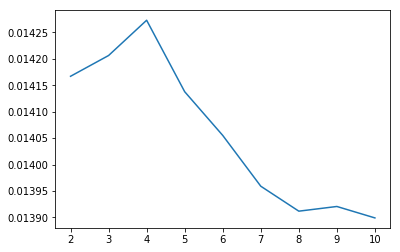

In [20]:
b=[2,3,4,5,6,7,8,9,10]
plt.plot(b,ac)

In [21]:
rf = RandomForestRegressor(min_samples_split=10)
rf.fit(X_train, y_train)

c:\users\akshay\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
predicted_test = rf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predicted_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predicted_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted_test)))

Mean Absolute Error: 0.004206728196303944
Mean Squared Error: 0.0001891399980501259
Root Mean Squared Error: 0.013752817822181965


### Converting Scrapped data into features

In [23]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
def rate_nonstop_words(words):
    words=tokenize(words)
    filtered_sentence = [w for w in words if not w in stopwords]
    n_of_order = list(set(filtered_sentence))
    rate_unique_nonstop=len(n_of_order)/len(words)
    return rate_unique_nonstop
def avg_token(words):
    words=tokenize(words)
    length=[]
    for i in words:
        length.append(len(i))
    return np.average(length)
from textblob import TextBlob
import datefinder
import datetime  
from datetime import date 
def day(article_text):
    article=article_text
    if len(list(datefinder.find_dates(article)))>0:
        date=str(list(datefinder.find_dates(article))[0])
        date=date.split()
        date=date[0]
        year, month, day = date.split('-')     
        day_name = datetime.date(int(year), int(month), int(day)) 
        return day_name.strftime("%A")
    return "Monday"
def tokenize(text):
    text=text
    return word_tokenize(text)
pos_words=[]
neg_words=[]
def polar(words):
    all_tokens=tokenize(words)
    for i in all_tokens:
        analysis=TextBlob(i)
        polarity=analysis.sentiment.polarity
        if polarity>0:
            pos_words.append(i)
        if polarity<0:
            neg_words.append(i)
    return pos_words,neg_words
def rates(words):
    words=polar(words)
    pos=words[0]
    neg=words[1]
    all_words=words
    global_rate_positive_words=(len(pos)/len(all_words))/100
    global_rate_negative_words=(len(neg)/len(all_words))/100
    pol_pos=[]
    pol_neg=[]
    for i in pos:
        analysis=TextBlob(i)
        pol_pos.append(analysis.sentiment.polarity)
        avg_positive_polarity=analysis.sentiment.polarity
    for j in neg:
        analysis2=TextBlob(j)
        pol_neg.append(analysis2.sentiment.polarity)
        avg_negative_polarity=analysis2.sentiment.polarity
    min_positive_polarity=min(pol_pos)
    max_positive_polarity=max(pol_pos)
    min_negative_polarity=min(pol_neg)
    max_negative_polarity=max(pol_neg)
    avg_positive_polarity=np.average(pol_pos)
    avg_negative_polarity=np.average(pol_neg)
    return global_rate_positive_words,global_rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity


In [24]:
df2=[]
for i in news:
    pred_info={}
    article = Article(i, language="en")  
    article.download() 
    article.parse()
    analysis=TextBlob(article.text)
    polarity=analysis.sentiment.polarity
    title_analysis=TextBlob(article.title)
    pred_info['text']=article.text
    pred_info['n_tokens_title']=len(tokenize(article.title))
    pred_info['n_tokens_content']=len(tokenize(article.text))
    pred_info['n_non_stop_unique_tokens']=rate_nonstop_words(article.text)
    pred_info['num_hrefs']=article.html.count("https://news.yahoo.com")
    pred_info['num_imgs']=len(article.images)
    pred_info['num_videos']=len(article.movies)
    pred_info['average_token_length']=avg_token(article.text)
    pred_info['num_keywords']=len(article.keywords)
    
    if "life-style" in article.url:
        pred_info['data_channel_is_lifestyle']=1
    else:
        pred_info['data_channel_is_lifestyle']=0
    if "etimes" in article.url:
        pred_info['data_channel_is_entertainment']=1
    else:
        pred_info['data_channel_is_entertainment']=0
    if "business" in article.url:
        pred_info['data_channel_is_bus']=1
    else:
        pred_info['data_channel_is_bus']=0
    if "social media" or "facebook" or "whatsapp" in article.text.lower():
        data_channel_is_socmed=1
        data_channel_is_tech=0
        data_channel_is_world=0
    else:
        data_channel_is_socmed=0
    if ("technology" or "tech" in article.text.lower()) or ("technology" or "tech" in article.url):
        data_channel_is_tech=1
        data_channel_is_socmed=0
        data_channel_is_world=0
    else:
        data_channel_is_tech=0
    if "world" in article.url:
        data_channel_is_world=1
        data_channel_is_tech=0
        data_channel_is_socmed=0
    else:
        data_channel_is_world=0
        
    pred_info['data_channel_is_socmed']=data_channel_is_socmed
    pred_info['data_channel_is_tech']=data_channel_is_tech
    pred_info['data_channel_is_world']=data_channel_is_world
    
    if day(i)=="Monday":
        pred_info['weekday_is_monday']=1
    else:
        pred_info['weekday_is_monday']=0
    if day(i)=="Tuesday":
        pred_info['weekday_is_tuesday']=1
    else:
        pred_info['weekday_is_tuesday']=0
    if day(i)=="Wednesday":
        pred_info['weekday_is_wednesday']=1
    else:
        pred_info['weekday_is_wednesday']=0
    if day(i)=="Thursday":
        pred_info['weekday_is_thursday']=1
    else:
        pred_info['weekday_is_thursday']=0
    if day(i)=="Friday":
        pred_info['weekday_is_friday']=1
    else:
        pred_info['weekday_is_friday']=0
    if day(i)=="Saturday":
        pred_info['weekday_is_saturday']=1
        pred_info['is_weekend']=1
    else:
        pred_info['weekday_is_saturday']=0
    if day(i)=="Sunday":
        pred_info['weekday_is_sunday']=1
        pred_info['is_weekend']=1
    else:
        pred_info['weekday_is_sunday']=0
        pred_info['is_weekend']=0
        
    pred_info['global_subjectivity']=analysis.sentiment.subjectivity
    pred_info['global_sentiment_polarity']=analysis.sentiment.polarity
    pred_info['global_rate_positive_words'],pred_info['global_rate_negative_words'],pred_info['avg_positive_polarity'],pred_info['min_positive_polarity'],pred_info['max_positive_polarity'],pred_info['avg_negative_polarity'],pred_info['min_negative_polarity'],pred_info['max_negative_polarity']=rates(article.text)
       
    pred_info['title_subjectivity']=title_analysis.sentiment.subjectivity
    pred_info['title_sentiment_polarity']=title_analysis.sentiment.polarity
    df2.append(pred_info)

In [27]:
prediction=pred_df.drop(['text'],axis=1)

In [29]:
x = prediction.values #returns a numpy array
cols=list(prediction.columns)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
prediction = pd.DataFrame(x_scaled,columns=cols)

In [33]:
test=pd.DataFrame(rf.predict(prediction),pred_df['text'])
test.reset_index(level=0, inplace=True)
test = test.rename(index=str, columns={"index": "News", 0: "Likelihood of Virality"})
test

,text,Likelihood of Virality
0,"Vice President Joe Biden, left, laughs with fo...",0.038445
1,Guillaume Soro lives in France and was not pre...,0.039959
2,"WASHINGTON, April 28, 2020 /PRNewswire/ -- Fam...",0.028922
3,"The logos of Spain's soccer teams Barcelona, l...",0.038886
4,Shoppers out and about in Berlin as the German...,0.038364
5,"ANKARA, Turkey (AP) — A fuel tanker exploded T...",0.034520
6,"FILE - In this June 24, 2019 file photo, the e...",0.035204
7,An Indian Muslim man prays in a Mosque during ...,0.042584
8,African countries have fewer coronavirus cases...,0.044143
9,"Gen Haftar said he had ""a popular mandate"" to ...",0.035827
